In [1]:
import torch as t
from torch.nn.functional import normalize
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor
import torch.utils.data as D
from torch.utils.data import TensorDataset

## Dataset preparations

In [29]:
def make_windowed_data():
    dataset = t.load("data/ffa_channelpark.pt", weights_only=False)
    observations, rewards = dataset.tensors
    positions = observations[:,:2].float()
    
    windowed = positions.unfold(dimension=0, size=10, step=1)  # (b, 2, 10)
    windowed_rewards = rewards.unfold(dimension=0,size=10, step=1) # (b, 10)
    good_windows = windowed[windowed_rewards.pow(2).sum(-1) == 0]

    diffs = good_windows.diff(dim=-1)
    print(diffs[1000])
    x = diffs[:, :, :-1]
    y = diffs[:, :, -1]
    print(x.shape)
    return x.flatten(start_dim=1, end_dim=-1), y
    
x, y = make_windowed_data()
t.linalg.cond(x)


tensor([[-0.0015, -0.0015, -0.0005, -0.0005,  0.0005,  0.0015,  0.0015,  0.0020,
          0.0020],
        [ 0.0054,  0.0054,  0.0054,  0.0059,  0.0049,  0.0049,  0.0049,  0.0039,
          0.0044]])
torch.Size([2325306, 2, 8])


tensor(110.3125)

## 

In [54]:
new_x[1000].reshape(9, -1)

tensor([[ 5.6192e-01,  5.8614e-01,  6.5280e-01,  6.7508e-01],
        [ 7.0330e-01,  2.2941e-02,  6.7790e-01,  9.7699e-01],
        [ 9.6463e-01, -4.8165e-01, -4.4465e-01, -3.2640e-01],
        [-2.1096e-01, -1.2787e-01,  0.0000e+00,  8.7471e-02],
        [ 1.8319e-01,  1.2862e-01, -1.0383e-01, -1.0730e-01],
        [-1.1107e-01, -1.1771e-01, -1.1923e-01,  8.7987e-02],
        [-3.6090e-03,  7.4538e-04,  1.3973e-03,  6.6444e-01],
        [ 6.6874e-01,  6.7452e-01,  6.9707e-01,  6.8906e-01],
        [-9.9586e-01,  7.2992e-01, -1.0923e-01, -2.3009e-01]])

## Constant model

In [26]:
mse  = mean_squared_error(0 * x.reshape(-1, 2, 8)[:, :, -1], y)
print("Constant model error:\t",mse)
mse  = mean_squared_error(x.reshape(-1, 2, 8)[:, :, -1], y)
print("Baseline error:\t",mse)

Constant model error:	 7.70117951956225e-06
Baseline error:	 2.0381450300102904e-07


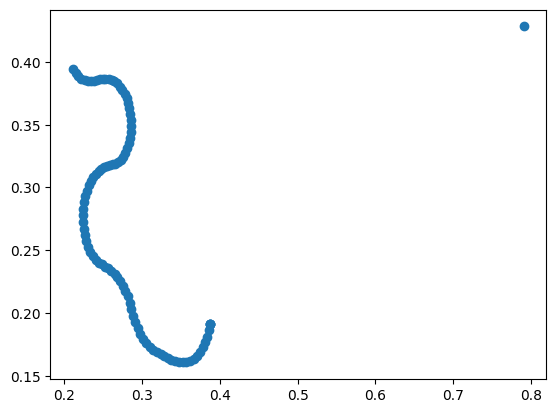

In [66]:
import matplotlib.pyplot as plt

def show_traj(x):
    plt.scatter(x[:, 0], x[:, 1])

    
show_traj(positions[1000:1100, :2])

In [70]:
def inertial_baseline(x):
    return 2 * x[1:-1] - x[:-2]

mse  = mean_squared_error(positions[2:, :2], inertial_baseline(positions[:, :2]))
print("Mean squared error for inertial:\t",mse)
mse  = mean_squared_error(positions[1:, :2], positions[:-1, :2])
print("Mean squared error for constant:\t",mse)

Mean squared error for inertial:	 0.0010457706983428555
Mean squared error for constant:	 0.000529948268385962


##  Linear Regression

In [32]:
reg = LinearRegression().fit(x, y)
y_pred = reg.predict(x)
mse  = mean_squared_error(y, y_pred)
print("Mean squared error:\t",mse)

TypeError: RegressorMixin.score() missing 2 required positional arguments: 'X' and 'y'

## Multioutput Regression using SGD

In [50]:
model = MultiOutputRegressor(SGDRegressor(loss="squared_error",tol=1e-3)).fit(X, y)
y_pred = model.predict(X)
mse  = mean_squared_error(y, y_pred)
print("Mean squared error:\t",mse)

Mean squared error:	 0.0003713804898648525


### Again but with Max normalization

In [51]:
model = MultiOutputRegressor(SGDRegressor(loss="squared_error",tol=1e-3)).fit(X_scaled, y)
y_pred = model.predict(X_scaled)
mse  = mean_squared_error(y, y_pred)
print("Mean squared error:\t",mse)



Mean squared error:	 0.0217948220161012


## Torch's linear layer

In [39]:
from tqdm import tqdm

def run_sgd(X, y, lr=1e-3, epochs=1001):
    model = t.nn.Linear(X.shape[1], 4).to(t.float32)
    opt = t.optim.SGD(lr=lr, params=model.parameters())
    loss_fn = t.nn.MSELoss()
    
    for i in range(epochs):
         train_loss = loss_fn(y, model(X))
         opt.zero_grad()
         train_loss.backward()
         opt.step()
         if i % 50 == 0:
             print(f'Train loss {i}: \t{train_loss}')
        
run_sgd(new_x, new_y, lr=1, epochs=400)

Train loss 0: 	0.07252107560634613
Train loss 50: 	0.001315273460932076
Train loss 100: 	0.00080321473069489
Train loss 150: 	0.0006105336360633373
Train loss 200: 	0.0005115606472827494
Train loss 250: 	0.00045425299322232604
Train loss 300: 	0.00041914309258572757
Train loss 350: 	0.00039691064739599824


### Again but with Max normalization

In [53]:
model = t.nn.Linear(40, 4).to(t.float32)
opt = t.optim.SGD(lr=1e-3, params=model.parameters())
loss_fn = t.nn.MSELoss()
for i in range(1001):
     train_loss = loss_fn(y, model(X_scaled))
     if i%200==0:
          print(f'Train loss for iteration {i}:\t{train_loss}')
     opt.zero_grad()
     train_loss.backward()
     opt.step()

Train loss for iteration 0:	0.5132244229316711
Train loss for iteration 200:	0.4241345524787903
Train loss for iteration 400:	0.3511976897716522
Train loss for iteration 600:	0.2914852201938629
Train loss for iteration 800:	0.24259929358959198
Train loss for iteration 1000:	0.20257702469825745


### Again but using batches 

In [48]:
def run_sgd_batched(X, y, lr, batch=1024, epochs=500):
    dataset = TensorDataset(X, y)
    train_loader = D.DataLoader(dataset, batch_size=batch, shuffle=False)
    model = t.nn.Linear(X.shape[1], 4).to(t.float32)
    opt = t.optim.SGD(lr=lr, params=model.parameters())
    loss_fn = t.nn.MSELoss()
    for j in range(epochs):
        print("starting epoch")
        for i, (b_x, b_y) in enumerate(train_loader):
          train_loss = loss_fn(b_y, model(b_x))
          opt.zero_grad()
          train_loss.backward()
          opt.step()
        print(f'Train loss for epoch {j}:\t{train_loss}')

In [49]:
run_sgd_batched(new_x, new_y, 0.5)

starting epoch
Train loss for epoch 0:	0.000379081757273525
starting epoch
Train loss for epoch 1:	0.0003736683283932507
starting epoch
Train loss for epoch 2:	0.0003718721563927829
starting epoch
Train loss for epoch 3:	0.00037098114262335
starting epoch
Train loss for epoch 4:	0.000370435300283134
starting epoch
Train loss for epoch 5:	0.0003700553497765213
starting epoch


KeyboardInterrupt: 